In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("/home/yatindandi/anaconda3/envs/myenv/lib/python3.7/site-packages/gym")
sys.path.append("/data/yatind/anaconda3/lib/python3.7/site-packages (0.10.8)")
import gym
import os
import gc
from gym.wrappers import Monitor
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

env = gym.make('CartPole-v1')
device = torch.device("cuda")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
state = env.reset()
state = torch.from_numpy(state).float().unsqueeze(0)
print(state.shape)

torch.Size([1, 4])


In [4]:
class REINFORCE(nn.Module):
    def __init__(self):
        super(REINFORCE, self).__init__()
        self.head = nn.Sequential(
            nn.Linear(4, 256),nn.ReLU(),nn.Linear(256, 2),nn.Softmax(dim=-1))
            
    def forward(self, x):
        x = self.head(x)
        return x

In [5]:
policy_net = REINFORCE().to(device)

In [6]:
optimizer = optim.Adam(policy_net.parameters(),lr = 0.01)

In [7]:
episode_lengths = []
def learn(env,num_episodes,gamma):
    avg_length = 0
    for i_episode in range(num_episodes):
          rewards = []
          scores = []
          state = env.reset()
          loss = None
          for t in range(1000):
              state = torch.from_numpy(state).float().unsqueeze(0).to(device)
              probs = policy_net(state)
              m = Categorical(probs)
              action = m.sample()
              scores.append(m.log_prob(action))
              with torch.no_grad():
                  state, reward, done, _ = env.step(action.data[0].item())
              rewards.append(reward)
              if done:
                break
              
          episode_lengths.append(t)
          value = 0
          loss = 0
          values = []
          for reward in rewards[::-1]:
              value  = gamma*value + reward
              values.append(value)
          values = torch.tensor(values).to(device)
          values = (values - values.mean()) / (values.std())
          for i,value in enumerate(values):
              loss -=  value*scores[-(i+1)]
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          avg_length += episode_lengths[i_episode]
          if (i_episode%200==0):
              print(avg_length/200)
              avg_length = 0

    return
              
         

    
    

In [8]:
learn(env,10000,0.99)

0.065
59.575
105.01
129.775
46.415
97.3
56.31
76.455
80.14
89.54
78.68
98.685
76.795
122.805
158.345
94.015
146.375
106.965
108.725
110.315
198.63
132.725
245.775
152.525
141.39
145.33
117.035
91.555
85.58
71.885
85.235
150.355
169.22
259.405
285.845
263.115
255.315
162.53
163.655
162.87
127.13
182.625
424.36
497.525
499.0
499.0
499.0
495.255
383.34
455.475


In [9]:
matplotlib.style.use('ggplot')

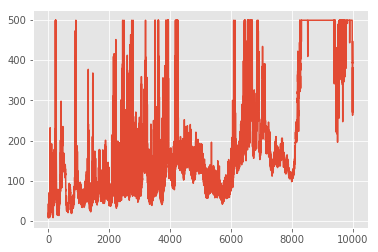

In [13]:
y = np.array(episode_lengths)
x = np.arange(10000)
plt.plot(x, y)
plt.show() 